In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata


In [3]:
def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)

In [4]:
def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

In [5]:
def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]

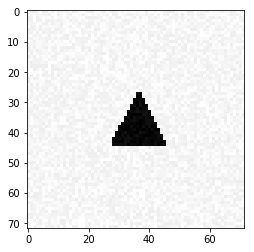

In [6]:
im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

In [7]:
def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [8]:
def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = to_categorical(Y_test, 3) 
    return [X_test, Y_test]

In [9]:
def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [10]:
def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

In [11]:
def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

In [81]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.utils import to_categorical, normalize
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.layers import Flatten 
from tensorflow.keras.layers import Dropout


## 3 - Simple Classifier

In [13]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
Y_train = to_categorical (Y_train)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [14]:
dim =X_train.shape[1]

### With SGD

In [15]:
model = Sequential()
model.add(Dense(3, kernel_initializer='uniform', input_shape=(dim,))) 
model.add(Activation('softmax'))

In [16]:
sgd = SGD(lr=0.001,decay=1e-5, momentum=0.6,nesterov=True)
model.compile(loss='categorical_crossentropy',optimizer=sgd, metrics=['accuracy'])

In [17]:
model.fit(X_train, Y_train, epochs=20, validation_split=0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 0s 2ms/step - loss: 1.2948 - acc: 0.3333 - val_loss: 1.1043 - val_acc: 0.3500
Epoch 2/20
240/240 [==============================] - 0s 229us/step - loss: 0.9551 - acc: 0.5000 - val_loss: 0.9793 - val_acc: 0.4500
Epoch 3/20
240/240 [==============================] - 0s 220us/step - loss: 0.8578 - acc: 0.5875 - val_loss: 0.6521 - val_acc: 0.7000
Epoch 4/20
240/240 [==============================] - 0s 223us/step - loss: 0.7860 - acc: 0.6167 - val_loss: 0.6435 - val_acc: 0.8167
Epoch 5/20
240/240 [==============================] - 0s 242us/step - loss: 0.6982 - acc: 0.7000 - val_loss: 0.5871 - val_acc: 0.8000
Epoch 6/20
240/240 [==============================] - 0s 237us/step - loss: 0.6268 - acc: 0.7125 - val_loss: 0.6114 - val_acc: 0.7500
Epoch 7/20
240/240 [==============================] - 0s 232us/step - loss: 0.5910 - acc: 0.7792 - val_loss: 0.5534 - val_acc: 0.7667
Epoch 8/20
240/240 

In [18]:
X_test = generate_a_disk() 
X_test = X_test.reshape(1, X_test.shape[0])

In [19]:
model.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [20]:
predictions=model.predict(X_test)
predictions[0]
np.argmax(predictions[0])

1

### With Adam

In [21]:
modeladam = Sequential()
modeladam.add(Dense(3, kernel_initializer='uniform', input_shape=(dim,))) 
modeladam.add(Activation('softmax'))  

modeladam.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
modeladam.fit(X_train, Y_train,batch_size=32,epochs=15,validation_split=0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/15
240/240 [==============================] - 0s 1ms/step - loss: 1.6714 - acc: 0.3583 - val_loss: 0.7418 - val_acc: 0.7333
Epoch 2/15
240/240 [==============================] - 0s 245us/step - loss: 0.7548 - acc: 0.6917 - val_loss: 0.7232 - val_acc: 0.8333
Epoch 3/15
240/240 [==============================] - 0s 253us/step - loss: 0.6569 - acc: 0.7333 - val_loss: 0.6513 - val_acc: 0.7167
Epoch 4/15
240/240 [==============================] - 0s 257us/step - loss: 0.4840 - acc: 0.7792 - val_loss: 0.3280 - val_acc: 0.8667
Epoch 5/15
240/240 [==============================] - 0s 254us/step - loss: 0.3355 - acc: 0.9125 - val_loss: 0.3290 - val_acc: 0.8667
Epoch 6/15
240/240 [==============================] - 0s 231us/step - loss: 0.3004 - acc: 0.9250 - val_loss: 0.2340 - val_acc: 0.9667
Epoch 7/15
240/240 [==============================] - 0s 229us/step - loss: 0.2501 - acc: 0.9708 - val_loss: 0.2179 - val_acc: 0.9833
Epoch 8/15
240/240 

In [23]:
X_test = generate_a_disk()
X_test = X_test.reshape(1, X_test.shape[0])
modeladam.predict(X_test)

array([[0., 1., 0.]], dtype=float32)

In [24]:
predictions=modeladam.predict(X_test)
predictions[0]
np.argmax(predictions[0])

1

## 4 - Vizualisation

### SGD

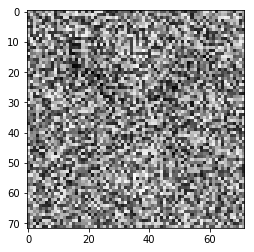

In [25]:
model.get_weights()
sgd_Viz=model.get_weights()[0]
im1=sgd_Viz[:,0]
im2=sgd_Viz[:,1]
im3=sgd_Viz[:,2]
plt.imshow(im1.reshape(72, 72), cmap='gray')

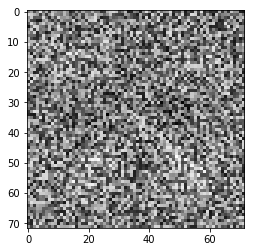

In [26]:
plt.imshow(im2.reshape(72, 72), cmap='gray')

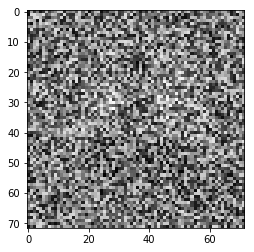

In [27]:
plt.imshow(im3.reshape(72, 72), cmap='gray')

### Adam

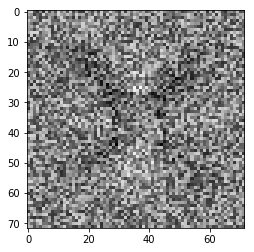

In [29]:
modeladam.get_weights()
Viz2=modeladam.get_weights()[0]
im1=Viz2[:,0]
im2=Viz2[:,1]
im3=Viz2[:,2]
plt.imshow(im1.reshape(72, 72), cmap='gray')

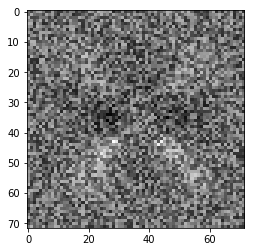

In [30]:
plt.imshow(im2.reshape(72, 72), cmap='gray')

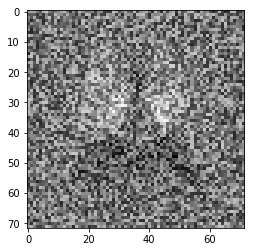

In [31]:
plt.imshow(im3.reshape(72, 72), cmap='gray')

## 5 - A More Difficult Classification Problem

In [49]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)
Y_train2 = to_categorical (Y_train)
X_train2 = X_train.reshape(X_train.shape[0], 72, 72, 1)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [50]:
[X_test, Y_test] = generate_test_set_classification()
model.evaluate(X_test, Y_test)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300/300 [==============================] - 0s 947us/step


[1.5233019399642944, 0.23666666666666666]

In [51]:
model2sgd = Sequential()
model2sgd.add(Conv2D(16,(5,5), input_shape=(72,72,1)))
model2sgd.add(Activation('relu'))
model2sgd.add(MaxPooling2D(pool_size=(2,2)))
model2sgd.add(Flatten())
model2sgd.add(Dense(64, activation='relu'))
model2sgd.add(Dense(3, activation='softmax'))

In [52]:
model2adam = Sequential()
model2adam.add(Conv2D(16,(5,5), input_shape=(72,72,1)))
model2adam.add(Activation('relu'))
model2adam.add(MaxPooling2D(pool_size=(2,2)))
model2adam.add(Flatten())
model2adam.add(Dense(64, activation='relu'))
model2adam.add(Dense(3, activation='softmax'))

In [53]:
#Model with gradient Descent optimizer:           
model2sgd.compile(loss='categorical_crossentropy', optimizer=sgd, metrics = ['accuracy'])
#Model with Adam optimizer:
model2adam.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [54]:
model2adam.fit(X_train2, Y_train2, batch_size = 100, epochs = 10,validation_split=0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 4s 18ms/step - loss: 3.3130 - acc: 0.3500 - val_loss: 2.1957 - val_acc: 0.3833
Epoch 2/10
240/240 [==============================] - 3s 15ms/step - loss: 1.8196 - acc: 0.4042 - val_loss: 1.5744 - val_acc: 0.2500
Epoch 3/10
240/240 [==============================] - 4s 15ms/step - loss: 1.4615 - acc: 0.3000 - val_loss: 1.2555 - val_acc: 0.2667
Epoch 4/10
240/240 [==============================] - 4s 15ms/step - loss: 1.1137 - acc: 0.4083 - val_loss: 1.1051 - val_acc: 0.3833
Epoch 5/10
240/240 [==============================] - 4s 15ms/step - loss: 1.1121 - acc: 0.3708 - val_loss: 1.0921 - val_acc: 0.3833
Epoch 6/10
240/240 [==============================] - 4s 15ms/step - loss: 1.0550 - acc: 0.3750 - val_loss: 1.0136 - val_acc: 0.4667
Epoch 7/10
240/240 [==============================] - 4s 16ms/step - loss: 1.0100 - acc: 0.5333 - val_loss: 1.0277 - val_acc: 0.5000
Epoch 8/10
240/240 [====

In [59]:
model2adam.evaluate(X_test.reshape(300, 72, 72, 1), Y_test)

300/300 [==============================] - 2s 6ms/step


[0.966218139330546, 0.5599999996026357]

In [57]:
model2sgd.fit(X_train2, Y_train2, batch_size = 100, epochs = 10, validation_split=0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/10
240/240 [==============================] - 4s 16ms/step - loss: 1.1210 - acc: 0.3417 - val_loss: 1.0982 - val_acc: 0.3500
Epoch 2/10
240/240 [==============================] - 3s 14ms/step - loss: 1.0976 - acc: 0.3458 - val_loss: 1.0864 - val_acc: 0.3833
Epoch 3/10
240/240 [==============================] - 3s 14ms/step - loss: 1.0899 - acc: 0.3458 - val_loss: 1.0791 - val_acc: 0.4333
Epoch 4/10
240/240 [==============================] - 3s 14ms/step - loss: 1.0815 - acc: 0.4042 - val_loss: 1.0690 - val_acc: 0.5833
Epoch 5/10
240/240 [==============================] - 3s 14ms/step - loss: 1.0720 - acc: 0.4792 - val_loss: 1.0638 - val_acc: 0.3833
Epoch 6/10
240/240 [==============================] - 3s 15ms/step - loss: 1.0688 - acc: 0.4167 - val_loss: 1.0511 - val_acc: 0.5333
Epoch 7/10
240/240 [==============================] - 4s 15ms/step - loss: 1.0605 - acc: 0.5000 - val_loss: 1.0460 - val_acc: 0.5333
Epoch 8/10
240/240 [====

In [60]:
model2sgd.evaluate(X_test.reshape(300, 72, 72, 1), Y_test)

300/300 [==============================] - 2s 6ms/step


[1.0485276651382447, 0.4866666658719381]

## 6 A Regression Problem

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990


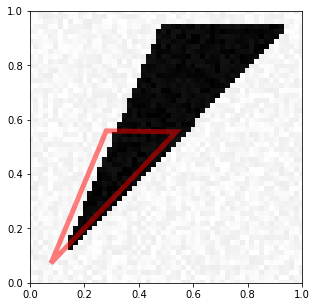

In [68]:
# 6 A Regression Problem
import matplotlib.patches as patches
import numpy as np
from sklearn import metrics
from sklearn import preprocessing

[X_train, Y_train] = generate_dataset_regression(2000, 20)
Y_train = preprocessing.normalize(Y_train, norm='l2')
visualize_prediction(X_train[1], Y_train[1])

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


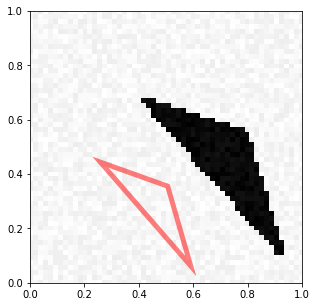

In [132]:
[X_test, Y_test] = generate_test_set_regression()
Y_test = preprocessing.normalize(Y_test, norm='l2')
visualize_prediction(X_test[5], Y_test[5])

In [131]:
def sort(Y):
    a = [Y[2*k] for k in range(3)]
    o = [Y[2*k+1] for k in range(3)]
    Y_sorted = []
    for i in range(3):    
        y_index = np.argmin(a)
        Y_sorted.append(a[y_index])
        Y_sorted.append(o[y_index])
        del a[y_index]
        del o[y_index]
    return Y_sorted

In [133]:
X_train4 = X_train.reshape(X_train.shape[0], 72, 72, 1)
Y_train4 = np.array([sort(Y_train[k]) for k in range(2000)])

In [136]:
X_test4 = X_test.reshape(X_test.shape[0], 72, 72, 1)
Y_test4 = np.array([sort(Y_test[k]) for k in range(300)])

In [137]:
modelreg = Sequential()
modelreg.add(Conv2D(32, activation='relu', input_shape=(72, 72, 1), kernel_size=(
5,5)))
modelreg.add(MaxPooling2D(pool_size=(2,2)))
modelreg.add(Conv2D(32, (5,5), activation="relu"))
modelreg.add(MaxPooling2D(pool_size=(2,2)))
modelreg.add(Conv2D(32, (5,5), activation="relu"))
modelreg.add(MaxPooling2D(pool_size=(2,2)))
modelreg.add(Flatten())
modelreg.add(Dense(256, activation='relu'))
modelreg.add(Dense(128, activation='relu'))
modelreg.add(Dense(6))

In [138]:
modelreg.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
modelreg.fit(X_train4, Y_train4, epochs=20, batch_size=32, validation_split=0.2, shuffle=True, verbose=1)

Train on 1600 samples, validate on 400 samples
Epoch 1/20
1600/1600 [==============================] - 151s 94ms/step - loss: 0.0308 - acc: 0.4788 - val_loss: 0.0184 - val_acc: 0.5200
Epoch 2/20
1600/1600 [==============================] - 154s 96ms/step - loss: 0.0152 - acc: 0.5781 - val_loss: 0.0127 - val_acc: 0.6175
Epoch 3/20
1600/1600 [==============================] - 175s 109ms/step - loss: 0.0112 - acc: 0.6663 - val_loss: 0.0087 - val_acc: 0.7175
Epoch 4/20
1600/1600 [==============================] - 160s 100ms/step - loss: 0.0080 - acc: 0.7194 - val_loss: 0.0075 - val_acc: 0.7325
Epoch 5/20
1600/1600 [==============================] - 147s 92ms/step - loss: 0.0064 - acc: 0.7562 - val_loss: 0.0057 - val_acc: 0.7550
Epoch 6/20
1600/1600 [==============================] - 149s 93ms/step - loss: 0.0052 - acc: 0.7913 - val_loss: 0.0050 - val_acc: 0.7650
Epoch 7/20
1600/1600 [==============================] - 150s 94ms/step - loss: 0.0045 - acc: 0.7950 - val_loss: 0.0044 - val_acc:

In [139]:
modelreg.evaluate(X_test4, Y_test4)

300/300 [==============================] - 8s 28ms/step


[0.003536250917240977, 0.8366666666666667]

In [143]:
y_pred = modelreg.predict(X_test4)

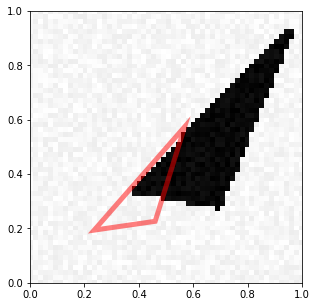

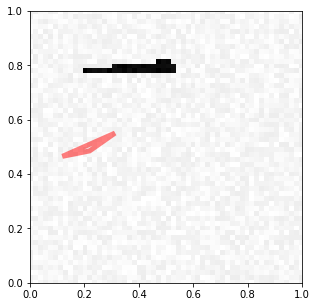

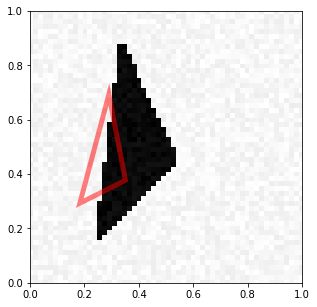

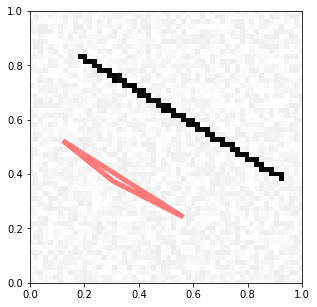

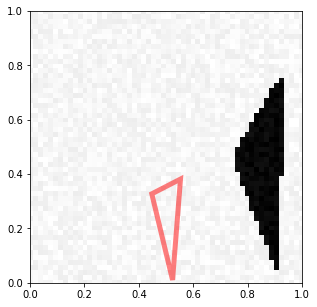

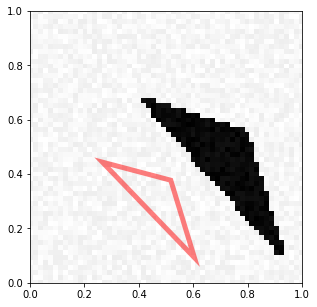

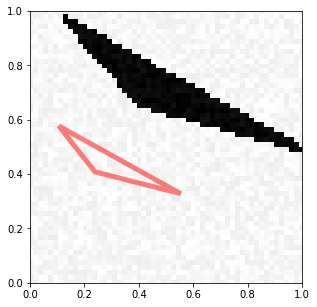

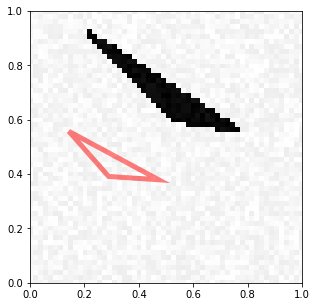

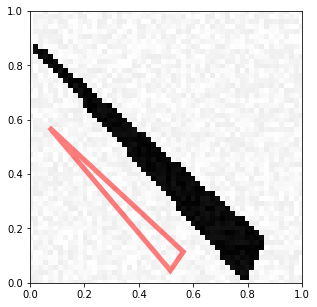

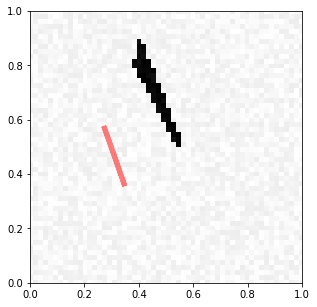

In [144]:
for k in range(10):
    visualize_prediction(X_test4[k], y_pred[k])

In [ ]:
chart_regression(pred.flatten(), Y_test)

# 7 Image Denoising

In [126]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing_noise(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle_noise(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing_noise(figsize, U, V, noise), generate_a_drawing_noise(figsize, U, V, 0)]


def generate_a_disk_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing_noise(figsize, U, V, noise), generate_a_drawing_noise(figsize, U, V, 0)]

def generate_a_triangle_noise(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return [generate_a_drawing_noise(figsize, U, V, noise), generate_a_drawing_noise(figsize, U, V, 0)] 
    
def generate_dataset_noise(nb_samples, free_location=False):
    # Getting im_size:
    noise = np.random.randint(0,100)  #generate noise value randomly
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,2,im_size])
    Y = np.zeros(nb_samples)
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle_noise(free_location)
        elif category == 1: 
            X[i] = generate_a_disk_noise(free_location)
        else:
            [X[i], V] = generate_a_triangle_noise(free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

In [127]:
[X_train5, Y_train5] = generate_dataset_classification_noise(600, free_location = True)
X_train5 = X_train5.reshape(X_train5.shape[0], 72, 72, 1) 
Y_train5 = Y_train5.reshape(Y_train5.shape[0], 72, 72, 1) 

In [128]:
model5 = Sequential()
model5.add(Conv2D(32, (3,3),activation='relu',input_shape=(72,72,1), padding='same'))

model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Conv2D(64, (3,3),activation='relu', padding='same'))

model5.add(MaxPooling2D(pool_size=(2, 2)))
model5.add(Conv2D(32, (3,3),activation='relu', padding='same'))

model5.add(UpSampling2D(size=(2, 2)))
model5.add(Conv2D(32, (3,3),activation='relu', padding='same'))
model5.add(UpSampling2D(size=(2, 2)))

model5.add(Conv2D(1, kernel_size=(3,3),activation='sigmoid', padding='same'))

model5.compile(loss='mean_squared_error', optimizer = 'adam' ,metrics=['accuracy'])
model5.fit(X_train5, Y_train5, epochs= 10, batch_size = 20, validation_split = 0.2)

Train on 480 samples, validate on 120 samples
Epoch 1/10
480/480 [==============================] - 82s 171ms/step - loss: 2.1079 - acc: 0.8996 - val_loss: 1.3232 - val_acc: 0.9091
Epoch 2/10
480/480 [==============================] - 81s 168ms/step - loss: 0.7375 - acc: 0.9519 - val_loss: 0.2277 - val_acc: 0.9887
Epoch 3/10
480/480 [==============================] - 79s 165ms/step - loss: 0.1670 - acc: 0.9893 - val_loss: 0.1501 - val_acc: 0.9896
Epoch 4/10
480/480 [==============================] - 82s 170ms/step - loss: 0.1272 - acc: 0.9917 - val_loss: 0.1097 - val_acc: 0.9929
Epoch 5/10
480/480 [==============================] - 78s 162ms/step - loss: 0.1091 - acc: 0.9931 - val_loss: 0.0973 - val_acc: 0.9939
Epoch 6/10
480/480 [==============================] - 79s 164ms/step - loss: 0.1044 - acc: 0.9933 - val_loss: 0.1612 - val_acc: 0.9884
Epoch 7/10
480/480 [==============================] - 81s 169ms/step - loss: 0.0963 - acc: 0.9937 - val_loss: 0.0824 - val_acc: 0.9949
Epoch 8/1

In [129]:
test_set, _ = generate_dataset_noise(10, 20)

X_test5 = test_set[:,0]
Y_test5 = test_set[:,1]
X_test5 = X_test.reshape(10,72,72,1)
Y_test5 = Y_test.reshape(10,72,72,1)

0


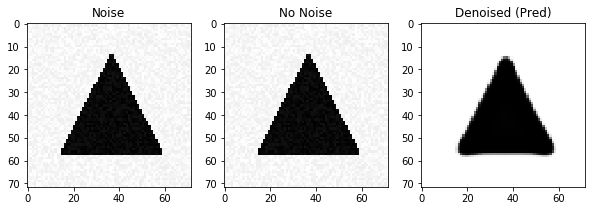

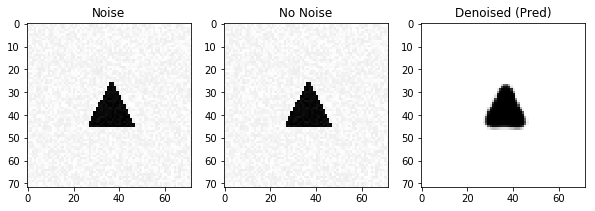

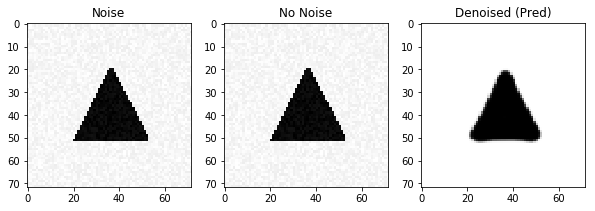

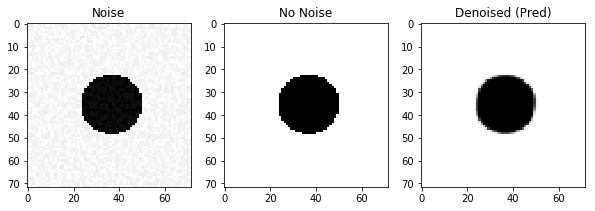

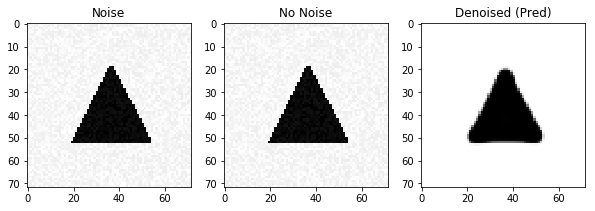

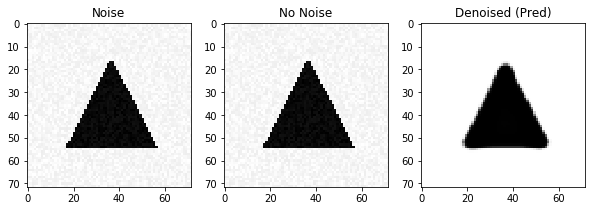

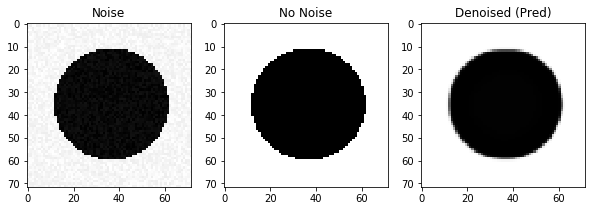

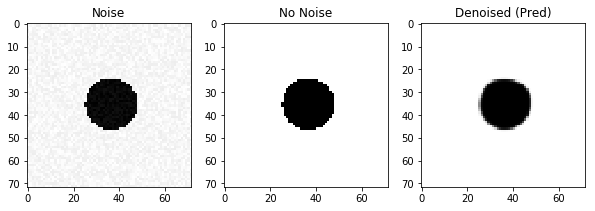

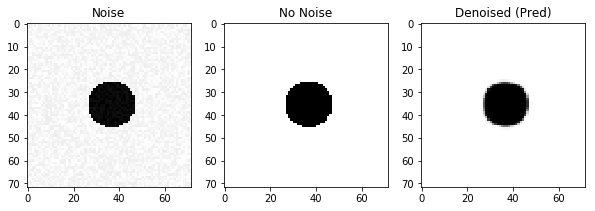

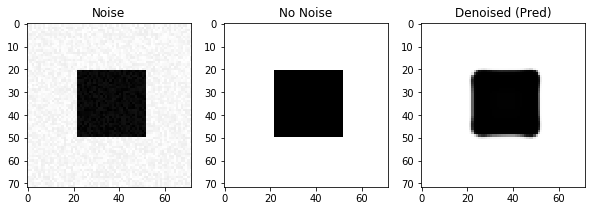

In [130]:
for i in range(10):
    fig = plt.figure(figsize = (10,20))

    plt.subplot(1, 3, 1)
    plt.imshow(X_test5[i].reshape(72,72), cmap='gray')
    plt.title("Noise")
    
    plt.subplot(1, 3, 2)
    plt.imshow(Y_test5[i].reshape(72,72), cmap='gray')
    plt.title("No Noise")
    
    plt.subplot(1, 3, 3)
    plt.imshow((model5.predict(X_test5[i].reshape((1,72,72,1))).reshape(72,72)), cmap='gray')
    plt.title("Denoised (Pred)")
